In [30]:
#import nessesary packages 
import pandas as pd
import numpy as np
import string
import nltk
nltk.download('stopwords')
import contractions
from spellchecker import SpellChecker
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from afinn import Afinn
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, LSTM, Dropout, Embedding
from keras.models import Sequential
from sklearn.metrics import accuracy_score, precision_score, recall_score, jaccard_score, log_loss
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix as pcm
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [23]:
#set panda settings to display all data untruncated 
pd.set_option('display.max_colwidth', -1)

In [24]:
#read scraped raw data 
data = pd.read_json('clothingreviewdata.json')
data[3042:3047]

,review,star,title
3042,"[\n Overall, the quality has improved from the past. Additionally the Customer Service is great and they will respond fast. Great for cute, trendy clothes! They have really cute bikinis, dresses, sunglasses and tops. Additionally, the prices are great for someone on a budget. The shipping can be a bit slow at times (depending on how much you order), but everything else is great!\n ]",5 stars: Excellent,Great
3043,[\n As an update. I purchased numerous bathing suits at in middle of January. 15 email to Zaful with order number and item number for return label. No return label ever sent 3 weeks into February. The bathing suit was not attractive. They reply over and over that I should have looked at sizing. The bathing suit fit it was just unholy thin and cheap looking. They do not send return label just endless reply statements w no return label. Lost my business forever\n ],1 star: Bad,As an update
3044,"[\n My son wanted a sweatshirt from ZAFUL. I ordered the sweatshirt on December 31st. It showed it was in stock and available. I also decided to order a different sweatshirt for myself. I received my sweatshirt in about two weeks. I normally wear size S but ordered a large because i wanted it roomy to layer. Well...the L was way too small and now it has a rip in it. , As of Feb 16th I was still waiting for my son’s sweatshirt. It was on backorder at the time I got mine. I did the chat in the beginning of feb and they said I couldn’t get my money back, only an exchange or points? They also implied that I ordered it when it said they were out of stock....ummm? No. Why would I do that? Anyway, They said it should be delivered around the 14th if I wanted to wait. I waited then contacted again and again they said I couldn’t get a refund. I finally messaged them a couple of days ago on FB and told them to refund my money and they finally did it. What a mess. I don’t want to go through that hassle again.\n ]",1 star: Bad,My son wanted a sweatshirt from ZAFUL
3045,[\n The first time I came across a Zaful page I immediately didn't trust the sight until I started seeing my friends order from them. I live in South Africa so I was skeptical at first... until I ordered bikinis taking a chance. I placed an order on a Tuesday and received it the following monday! i was so impressed. The bikini qualities were soooo good and I wore the one I bought this past weekend and it looked great! Best shopping experience ever!! would totally recommend them.\n ],5 stars: Excellent,My first experience with Zaful...
3046,[\n I love zaful so much great quality for great prices. I buy from them all the time. I love all their swimsuits!!\n ],5 stars: Excellent,I love zaful!!!


In [25]:
#clean "star" column of dataframe and split string at each word 
data['star'] = (data['star']).astype(str)
data['star'] = data['star'].replace('\s+', ' ')
data['star'] = data['star'].str.split(' ')

#create empty "unsatisfied" data column 
data['unsatisfied'] = ''

#recode data to populated "unsatisfied" column based on number of stars reviewers gave
for i in range(len(data)):
    if data['star'][i][0] == '5':
        data['unsatisfied'][i] = 0
    elif data['star'][i][0] == '1' or  data['star'][i][0] == '2':
        data['unsatisfied'][i] = 1
    else:
        data['unsatisfied'][i] = np.NaN
        
#drop data with mid-tier reviews where "unsatisfied" column was not encoded 
data = data.dropna(subset = ['unsatisfied'])
data['unsatisfied'] = data['unsatisfied'].astype(int)

In [26]:
#clean text from "review" column of dataframe keeping appropriate punctuation and capitalizations
data['review'] = (data['review']).astype(str)
data['review'] = (data['review']).str.replace('\s+', ' ')
data['review'] = data['review'].str.strip("""['""")
data['review'] = data['review'].str.strip("""']'""")
data['review'] = data['review'].str.replace("""', '""", '')
data['review'] = data['review'].str.replace("""", '""", '')
data['review'] = data['review'].str.replace("""', " """, '')
data['review'] = data['review'].str.strip("""\ """)
data['review'] = data['review'].str.strip('n')
data['review'] = data['review'].str.strip("""\ """)

In [27]:
#split string in "review" column of dataframe by the word
data['review'] = data['review'].str.split(' ')
#drop data were "review" column of dataframe does not have sufficient text
data = data[data['review'].map(lambda x: len(x)) > 1] 
data = data.reset_index(drop=True)
data.shape

(6749, 4)

In [28]:
#correct misspellings in text
spell = SpellChecker(distance=1)

for i in data.index:
    data['review'][i]=[spell.correction(word) for word in data['review'][i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [31]:
stopword = stopwords.words('english')

data['review'] = data['review'].apply(lambda x: [word for word in x if word not in stopword])

In [32]:
#get total number of unique words in "review" column of dataframe
unique = set(data['review'].sum())
print('number of unique words in dataset ' + str(len(unique)))

number of unique words in dataset 19890


In [33]:
#get summary statitistics about the number of words in each review 
data['number_of_words'] = data['review'].apply(lambda x: len(x))
print('maximum number of words in a single review: ' + str(data['number_of_words'].max()))
print('average number of words in a single review: ' + str(data['number_of_words'].mean()))
print('median number of words in a single review: ' + str(data['number_of_words'].median()))
print('most common number of words in a single review: ' + str(float(data['number_of_words'].mode())))

maximum number of words in a single review: 604
average number of words in a single review: 48.25366720995703
median number of words in a single review: 41.0
most common number of words in a single review: 43.0


In [34]:
#rejoin data
for i in range(len(data)):
    data['review'][i] =' '.join([str(elem) for elem in data['review'][i]])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
data[3042:3047]

,review,star,title,unsatisfied,number_of_words
3042,I ordered two bathing suits Zaful fantastic prices It may take bit bathing suit ship arrived delivered looked exactly pictured If want trendy bathing suits cheap best website it.,"[5, stars:, Excellent]",amazing,0,29
3043,"Great customer service highly appreciated ', far I havent disappointed ordered products reviews helpful comes sizing well see product looks like I recommended Zaful friends swimwear I find selection broad please anybody's personal taste."", can't wait receive next order.\n ""","[5, stars:, Excellent]",About Zaful,0,40
3044,helpful webside fast shipping.Great experience,"[5, stars:, Excellent]",Zaful,0,5
3045,Zaful cheap high quality things sell Lots range something everyone fast shipping lovely customer service willing help Have told friends continue,"[5, stars:, Excellent]",Zaful is awesome,0,21
3046,Very happy purchases Cheap prices high quality bathing suits Fast shipping Customer service helpful always responds prompt manner overall great experience Zaful. Will definitely shopping I highly recommend shopping,"[5, stars:, Excellent]",Very happy with my purchases,0,29


In [36]:
#create new dataframe for Afinn sentiment analysis
AfinnData = data
AfinnData['Afinn'] = ''
AfinnData['AfinnClass'] = ''

In [37]:
#apply Afinn sentiment score
afinn = Afinn()
AfinnData['Afinn'] = AfinnData['review'].apply(lambda review: afinn.score(review))

#recode so that sentiment score matches with "unsatisfied" column of the data frame
for i in AfinnData.index:
    if AfinnData['Afinn'][i] == 0:
        AfinnData['AfinnClass'][i] = np.NaN
    elif AfinnData['Afinn'][i] > 0:
        AfinnData['AfinnClass'][i] = 0
    else:
        AfinnData['AfinnClass'][i] = 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [38]:
#drop observations where Afinn sentiment score was ambiguous and clean data
AfinnData = AfinnData.dropna(subset = ['AfinnClass']).reset_index(drop=True)
AfinnData['AfinnClass'] = AfinnData['AfinnClass'].astype(int)

                 precision    recall  f1-score   support

  Satisfied (0)     0.9916    0.8390    0.9089      5050
Unsatisfied (1)     0.6196    0.9735    0.7572      1360

       accuracy                         0.8676      6410
      macro avg     0.8056    0.9063    0.8331      6410
   weighted avg     0.9126    0.8676    0.8767      6410

Afinn Classifier Jaccard Score: 0.6092959042797975


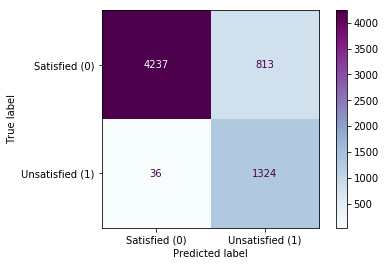

In [39]:
#create confusion matrix and evaluate
print (classification_report(AfinnData['AfinnClass'], AfinnData['unsatisfied'], labels=[0, 1], target_names=['Satisfied (0)', "Unsatisfied (1)"], digits=4))
cm = confusion_matrix(AfinnData['AfinnClass'], AfinnData['unsatisfied'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Satisfied (0)', "Unsatisfied (1)"])
disp = disp.plot(include_values=True, cmap='BuPu', xticks_rotation=None,)

print('Afinn Classifier Jaccard Score:', (jaccard_score(AfinnData['AfinnClass'], AfinnData['unsatisfied'], pos_label=1, average='binary')))

In [40]:
#create new dataframe for VADER sentiment analysis 
VADERSentData = data
VADERSentData['VADERSentNeg'] = ''
VADERSentData['VADERSentNeut'] = ''
VADERSentData['VADERSentPos'] = '' 
VADERSentData['VADERSentCom'] = ''
VADERSentData['VADERSentClass'] = ''

In [41]:
#apply VADER sentiment score
VADER = SentimentIntensityAnalyzer()
VADERSentData['Scores'] = VADERSentData['review'].apply(lambda review: VADER.polarity_scores(review))

VADERSentData['VADERSentNeg']  = VADERSentData['Scores'].apply(lambda score_dict: score_dict['neg'])
VADERSentData['VADERSentNeut']  = VADERSentData['Scores'].apply(lambda score_dict: score_dict['neu'])
VADERSentData['VADERSentPos']  = VADERSentData['Scores'].apply(lambda score_dict: score_dict['pos'])
VADERSentData['VADERSentCom']  = VADERSentData['Scores'].apply(lambda score_dict: score_dict['compound'])

#recode sentiment score to match with "unsatisifed" column of dataframe
for i in VADERSentData.index:
    if VADERSentData['VADERSentCom'][i] == 0:
        VADERSentData['VADERSentClass'][i] = np.NaN
    elif VADERSentData['VADERSentCom'][i] > 0:
        VADERSentData['VADERSentClass'][i] = 0
    else:
        VADERSentData['VADERSentClass'][i] = 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [42]:
#drop observations where VADER sentiment score was ambiguous and clean data
VADERSentData = VADERSentData.dropna(subset = ['VADERSentClass']).reset_index(drop=True)
VADERSentData = VADERSentData.drop(columns=['Scores'])
VADERSentData['VADERSentClass'] = VADERSentData['VADERSentClass'].astype(int)

                 precision    recall  f1-score   support

  Satisfied (0)     0.9905    0.8036    0.8873      5300
Unsatisfied (1)     0.5494    0.9687    0.7011      1310

       accuracy                         0.8363      6610
      macro avg     0.7699    0.8861    0.7942      6610
   weighted avg     0.9030    0.8363    0.8504      6610

VADER Classifier Jaccard Score: 0.5397703105061676


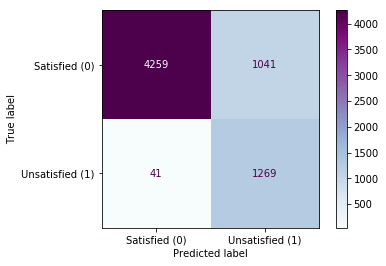

In [43]:
#create confusion matrix and evaluate
print (classification_report(VADERSentData['VADERSentClass'], VADERSentData['unsatisfied'], labels=[0, 1], target_names=['Satisfied (0)', "Unsatisfied (1)"], digits=4))
cm = confusion_matrix(VADERSentData['VADERSentClass'], VADERSentData['unsatisfied'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Satisfied (0)', "Unsatisfied (1)"])
disp = disp.plot(include_values=True, cmap='BuPu', xticks_rotation=None,)

print('VADER Classifier Jaccard Score:', (jaccard_score(VADERSentData['VADERSentClass'], VADERSentData['unsatisfied'], pos_label=1, average='binary')))

In [44]:
#tokenixe the top 5000 most common works and pad each review to 100 words
tokenizer = Tokenizer(num_words=5000, oov_token='<UNK>')
tokenizer.fit_on_texts((data['review']))
train_sequences = tokenizer.texts_to_sequences(data['review'])
X_tok = pad_sequences(train_sequences, padding='post', truncating='post', maxlen=100)
X_tok

array([[  69, 3748,   68, ...,  909,   72,  930],
       [   2,    6,  720, ...,    0,    0,    0],
       [   8,   27,  227, ...,    0,    0,    0],
       ...,
       [   4,    8,   18, ...,    0,    0,    0],
       [   4,  406,   40, ...,    0,    0,    0],
       [   2,   37,   24, ...,    0,    0,    0]], dtype=int32)

In [45]:
#create train-test split in dataset
X_train, X_test, y_train, y_test = train_test_split(X_tok, data['unsatisfied'], test_size=0.25, random_state=0)

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (5061, 100) (5061,)
Test set: (1688, 100) (1688,)


In [46]:
#create Long Short Term Memory model with custom word embeddings from dataset
keras_embedding = Sequential()
keras_embedding.add(Embedding(5000, 50, input_length=100))
keras_embedding.add(LSTM(units=50))
keras_embedding.add(Dense(1, activation='sigmoid'))
keras_embedding.add(Dropout(0.2))
keras_embedding.add(keras.layers.Flatten())
keras_embedding.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           250000    
_________________________________________________________________
lstm (LSTM)                  (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
_________________________________________________________________
dropout (Dropout)            (None, 1)                 0         
_________________________________________________________________
flatten (Flatten)            (None, 1)                 0         
Total params: 270,251
Trainable params: 270,251
Non-trainable params: 0
_________________________________________________________________


In [61]:
#compile and fit model on train data
keras_embedding.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
keras_embedding.fit(X_train, y_train, epochs=25, verbose=2)

Epoch 1/25
159/159 - 8s - loss: 1.1397 - acc: 0.9261
Epoch 2/25
159/159 - 6s - loss: 1.0875 - acc: 0.9289
Epoch 3/25
159/159 - 6s - loss: 1.1551 - acc: 0.9251
Epoch 4/25
159/159 - 6s - loss: 1.1703 - acc: 0.9241
Epoch 5/25
159/159 - 6s - loss: 1.1033 - acc: 0.9285
Epoch 6/25
159/159 - 6s - loss: 1.1246 - acc: 0.9271
Epoch 7/25
159/159 - 6s - loss: 1.0697 - acc: 0.9306
Epoch 8/25
159/159 - 6s - loss: 1.1794 - acc: 0.9235
Epoch 9/25
159/159 - 6s - loss: 1.0758 - acc: 0.9303
Epoch 10/25
159/159 - 6s - loss: 1.1489 - acc: 0.9255
Epoch 11/25
159/159 - 6s - loss: 1.1520 - acc: 0.9253
Epoch 12/25
159/159 - 6s - loss: 1.1154 - acc: 0.9277
Epoch 13/25
159/159 - 6s - loss: 1.0027 - acc: 0.9350
Epoch 14/25
159/159 - 6s - loss: 1.1611 - acc: 0.9247
Epoch 15/25
159/159 - 6s - loss: 1.1276 - acc: 0.9269
Epoch 16/25
159/159 - 6s - loss: 1.1794 - acc: 0.9235
Epoch 17/25
159/159 - 6s - loss: 1.1276 - acc: 0.9269
Epoch 18/25
159/159 - 6s - loss: 1.0422 - acc: 0.9324
Epoch 19/25
159/159 - 6s - loss: 1.03

In [62]:
#evaluate model loss and accuracy 
loss, accuracy = keras_embedding.evaluate(X_train, y_train, verbose=2)
print('Keras Deep Learning Model Accuracy', accuracy)
print('Keras Deep Learning Model Loss', loss)

159/159 - 2s - loss: 0.0049 - acc: 0.9994
Keras Deep Learning Model Accuracy 0.9994072318077087
Keras Deep Learning Model Loss 0.0048668235540390015


In [63]:
#use model to predict test data
keras_embedding_predications = keras_embedding.predict_classes(X_test)
keras_embedding_proba = keras_embedding.predict(X_test)

                 precision    recall  f1-score   support

  Satisfied (0)     0.9778    0.9832    0.9805      1073
Unsatisfied (1)     0.9704    0.9610    0.9657       615

       accuracy                         0.9751      1688
      macro avg     0.9741    0.9721    0.9731      1688
   weighted avg     0.9751    0.9751    0.9751      1688



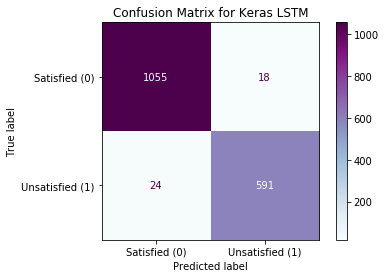

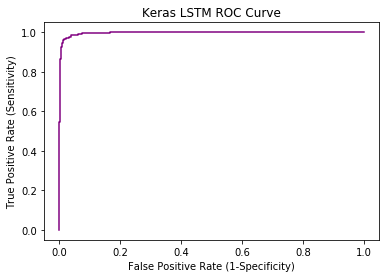

In [64]:
#create classification report
print (classification_report(keras_embedding_predications, y_test, labels=[0, 1], target_names=['Satisfied (0)', "Unsatisfied (1)"], digits=4))
#create confusion matrix
cm = confusion_matrix(keras_embedding_predications, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Satisfied (0)', "Unsatisfied (1)"])
disp = disp.plot(include_values=True, cmap='BuPu', xticks_rotation=None,)
disp.ax_.set_title('Confusion Matrix for Keras LSTM')

#create ROC curve
fpr, tpr, _= roc_curve(y_test, keras_embedding_proba)
ROC = plt.figure()
ROC = plt.plot(fpr, tpr, linestyle='-', color = 'purple', label='LTSM Model')
ROC = plt.title('Keras LSTM ROC Curve')
ROC = plt.xlabel('False Positive Rate (1-Specificity)')
ROC = plt.ylabel('True Positive Rate (Sensitivity)')